In [1]:
cd ..

C:\Users\mstark\Desktop\uw-msds-trac-capstone


In [2]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [3]:
# set constants
file_path = 'C:/Users/mstark/Desktop/uw-msds-trac-capstone/'
agg_level = '15min'

In [4]:
# read in test data, route clusters, and predictions
cdata = pd.read_csv(file_path + 'combined_data/' + agg_level + '/test_no_rr.tsv.gz', delimiter='\t')
cdata['rte'] = cdata['rte'].astype(float)
print(cdata.shape)

rte_clusters = pd.read_csv(file_path + 'evaluation/rte_clusters.tsv', delimiter='\t')

predictions = data = pd.read_csv(file_path + 'predictions/final_nn_' +  agg_level + '_test.txt', sep=" ", header=None)
predictions.columns = ['predicted_ons']
print(predictions.shape)

(59999, 20)
(59999, 1)


In [5]:
# spot check
print('Features: ', cdata.columns)
print('Shape: ', cdata.shape)
print(cdata.shape[0] == predictions.shape[0])

Features:  Index(['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns',
       'is_rapid', 'is_weekend', 'orca_total', 'frac_disabled', 'frac_youth',
       'frac_senior', 'frac_li', 'frac_uw', 'ons', 'region', 'start', 'end',
       'type', 'summer'],
      dtype='object')
Shape:  (59999, 20)
True


In [6]:
predictions.shape

(59999, 1)

In [7]:
rte_clusters[rte_clusters['trip_freq'] == 'high']

,rte,ntrips,trips_per_15,trip_freq
0,48,4975,1.138965,high
1,45,4893,1.120192,high
2,674,4831,1.105998,high
3,675,4782,1.094780,high
4,673,4753,1.088141,high
5,62,4707,1.077610,high
6,8,4539,1.039148,high
7,671,4528,1.036630,high
8,36,4480,1.025641,high
9,7,4407,1.008929,high


In [8]:
# merge test, predictions, and clusters
cdata['predicted_ons'] = predictions
cdata = pd.merge(cdata, rte_clusters, left_on='rte', right_on='rte', how = 'left')
cdata['diff'] = cdata['predicted_ons'] - cdata['ons']
cdata.head()

,opd_date,trip_start_hr_15,rte,dir,day_of_week,is_ns,is_rapid,is_weekend,orca_total,frac_disabled,...,region,start,end,type,summer,predicted_ons,ntrips,trips_per_15,trip_freq,diff
0,2019-01-07,00_0,10,N,0,1.0,0.0,0.0,5.0,0.008772,...,Seattle,Downtown Seattle,Capitol Hill,Trolley,False,11.693904,4052,0.927656,high,-3.306096
1,2019-01-07,00_0,44,N,0,1.0,0.0,0.0,0.0,0.000000,...,Seattle,Ballard,University District,Trolley,False,8.118879,4298,0.983974,high,2.118879
2,2019-01-07,00_0,132,S,0,1.0,0.0,0.0,8.0,0.000000,...,South King County,Downtown Seattle,Burien Transit Center,Conventional,False,19.994865,2679,0.613324,med,-7.005135
3,2019-01-07,00_0,235,S,0,1.0,0.0,0.0,3.0,0.000000,...,East King County,Kingsgate,Bellevue,Conventional,False,5.124784,2131,0.487866,med,-0.875216
4,2019-01-07,00_0,554,E,0,0.0,0.0,0.0,0.0,0.000000,...,Express,Downtown Seattle,Issaquah,Conventional,False,12.912284,2080,0.476190,med,2.912284


In [9]:
# validate merging
cdata[cdata['trip_freq'].isna()].shape

(0, 25)

# <center> Route Clusters <center>

In [10]:
# show summary statistics
freq_summary = cdata[['diff', 'trip_freq']].groupby(['trip_freq']).agg(['count', 'sum', 'median', 'mean', 'std']).reset_index()
freq_summary.head()

trip_freq   diff                                             
             count           sum    median      mean        std
0      high  12259 -29631.218423 -0.702488 -2.417099  10.669241
1       low  11684 -12275.415493 -0.162785 -1.050618   7.654560
2       med  36056 -48124.545547 -0.279725 -1.334717  11.040445

C:\Users\mstark\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


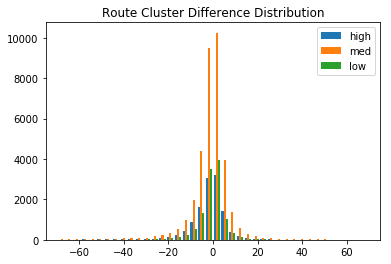

In [11]:
# Plot route cluster distributions
labels = ['high', 'med', 'low']
high_freq = cdata[cdata['trip_freq'] == labels[0]]['diff']
med_freq = cdata[cdata['trip_freq'] == labels[1]]['diff']
low_freq = cdata[cdata['trip_freq'] == labels[2]]['diff']

fig = plt.figure()
ax = plt.subplot(111)
plt.hist([high_freq, med_freq, low_freq], bins = 100)
plt.title('Route Cluster Difference Distribution')
plt.xlim(-75, 75)
ax.legend(labels)

fig.savefig(file_path + 'evaluation/bias_plots/' + agg_level + '/RteClusterDistribution.png')

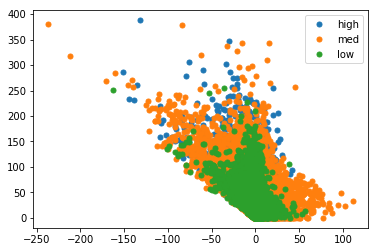

In [12]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for x in labels:
    data = cdata[cdata['trip_freq'] == x]
    ax.plot(data['diff'], data['ons'], marker='o', linestyle='', ms=5, label=x)
ax.legend()
plt.show()

In [13]:
### One-way ANOVA test
### Null hypothesis = Groups have the same population mean. 
### Low P-value = reject

f, p = stats.f_oneway(high_freq, med_freq, low_freq)
print ('One-way ANOVA')
print ('=============')
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 63.266086994847214
P value: 3.571252471016062e-28 



### 15min: Reject
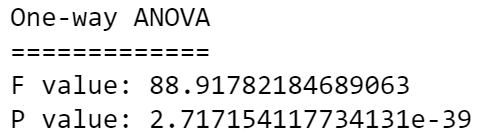

### 30min: Reject
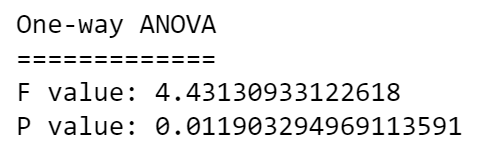

### 1hr: Reject
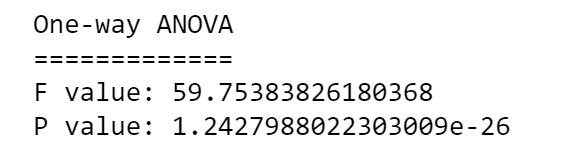

In [14]:
mc = MultiComparison(cdata['diff'], cdata['trip_freq'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 high   low    1.3665   1.0517  1.6813  True 
 high   med    1.0824   0.8278  1.3369  True 
 low    med   -0.2841  -0.5433 -0.0249  True 
---------------------------------------------


### 15min: High Frequency Different
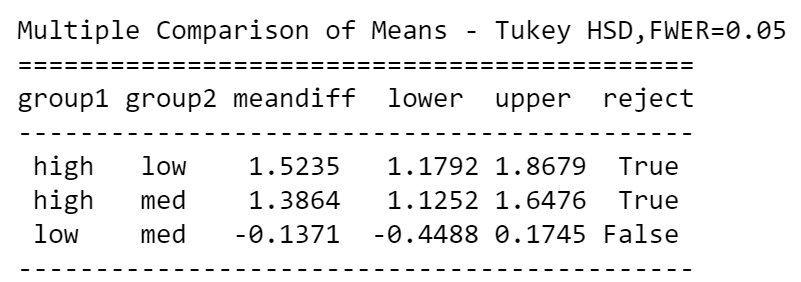

### 30min: Low Frequency Different 
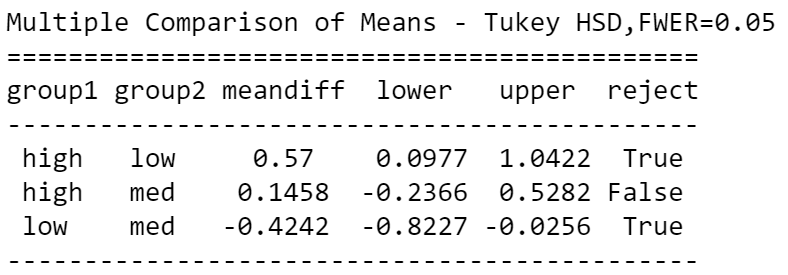

### 1hr: High Frequency Different
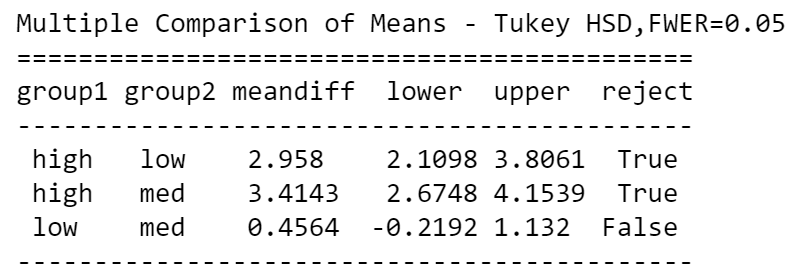

# <center> Top 10 Routes vs. Bottom 10 Routes <center>

In [16]:
rte_summary = cdata[['rte', 'diff', 'trip_freq']].groupby(['rte', 'trip_freq']).agg(['mean', 'std', 'count']).reset_index()
rte_summary.columns = rte_summary.columns.map(''.join)
rte_summary = rte_summary.sort_values('diffmean')
print('Top 10 Underestimated Routes')
print(rte_summary.head(10).sort_values('diffmean', ascending = True), '\n')
print('Top 10 Overestimated Routes')
print(rte_summary.tail(10).sort_values('diffmean', ascending = False), '\n')

Top 10 Underestimated Routes
       rte trip_freq  diffmean    diffstd  diffcount
40    57.0       low -5.071195   6.136568         17
15    18.0       low -4.962358   6.190050         22
13    15.0       low -4.552565   7.843039         41
106  212.0       low -4.335460  15.527192        237
27    36.0      high -4.146316  14.654054       1182
134  271.0       med -4.043845  15.539531        915
110  218.0       low -3.924821  12.408994        134
143  316.0       low -3.740268  11.450554         41
2      3.0       med -3.674622  14.053078        963
151  355.0       low -3.559586   9.666774         40 

Top 10 Overestimated Routes
       rte trip_freq  diffmean    diffstd  diffcount
162  556.0       low  2.377321  13.969013        126
139  308.0       low  1.566669   4.899441         15
119  237.0       low  1.231368   6.122071         30
155  540.0       low  0.918231   7.520497         83
124  244.0       low  0.731786   4.252088         53
86   167.0       low  0.708670   2.39401

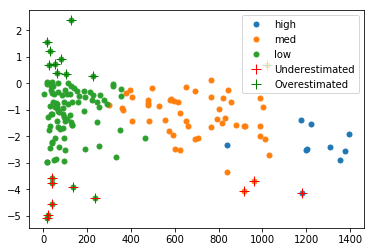

In [17]:
fig, ax = plt.subplots()
for x in labels:
    data = rte_summary[rte_summary['trip_freq'] == x]
    ax.plot(data['diffcount'], data['diffmean'], marker='o', linestyle='', ms=5, label=x)
ax.plot(rte_summary['diffcount'].head(10), rte_summary['diffmean'].head(10),
        marker='+', linestyle='', ms=10, color='red', label='Underestimated')
ax.plot(rte_summary['diffcount'].tail(10), rte_summary['diffmean'].tail(10),
        marker='+', linestyle='', ms=10, color='green', label='Overestimated')
ax.legend()
plt.show()

fig.savefig(file_path + 'evaluation/bias_plots/' + agg_level + '/OverUnderRtes.png')

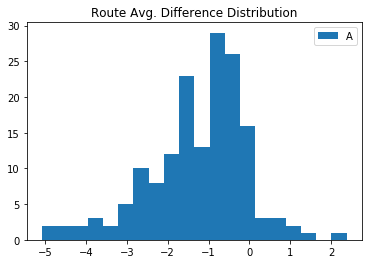

In [18]:
# Plot route cluster distributions
fig = plt.figure()
ax = plt.subplot(111)
plt.hist(rte_summary['diffmean'], bins = 20)
plt.title('Route Avg. Difference Distribution')
ax.legend('All Rtes')

fig.savefig(file_path + 'evaluation/bias_plots/' + agg_level + '/RteAvgDistribution_1.png')

C:\Users\mstark\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


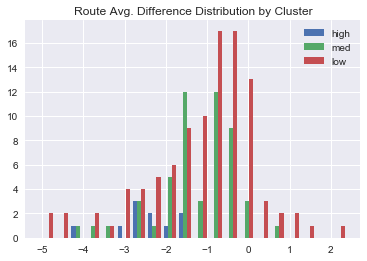

In [19]:
# Plot route cluster distributions
high_freq = rte_summary[rte_summary['trip_freq'] == labels[0]]['diffmean']
med_freq = rte_summary[rte_summary['trip_freq'] == labels[1]]['diffmean']
low_freq = rte_summary[rte_summary['trip_freq'] == labels[2]]['diffmean']

fig = plt.figure()
plt.style.use('seaborn')
ax = plt.subplot(111)
plt.hist([high_freq, med_freq, low_freq], bins = 20)
plt.title('Route Avg. Difference Distribution by Cluster')
ax.legend(labels)

fig.savefig(file_path + 'evaluation/bias_plots/' + agg_level + '/RteAvgDistribution_2.png')

In [20]:
f, p = stats.f_oneway(high_freq, med_freq, low_freq)
print ('One-way ANOVA')
print ('=============')
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 5.388284408200405
P value: 0.005436706938802968 



In [21]:
mc = MultiComparison(rte_summary['diffmean'], rte_summary['trip_freq'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 high   low    1.298    0.3624 2.2337  True 
 high   med    1.1686   0.194  2.1432  True 
 low    med   -0.1294  -0.6112 0.3523 False 
--------------------------------------------


### 15min: Reject
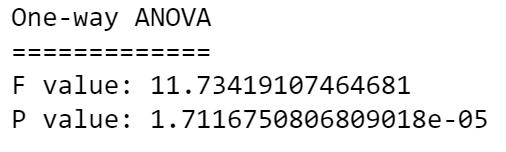

### 30min: Fail to Reject
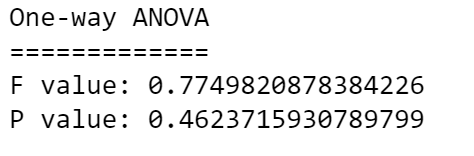

### 1hr: Reject
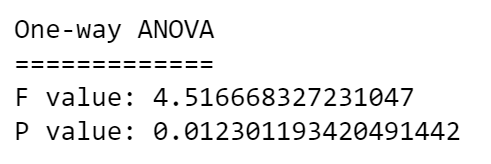

### 15min: High Frequency Different
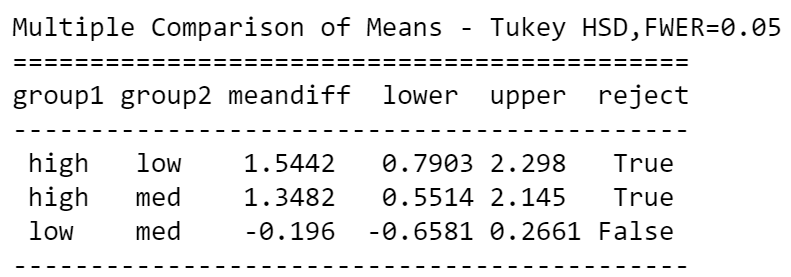

### 30min: No Difference 
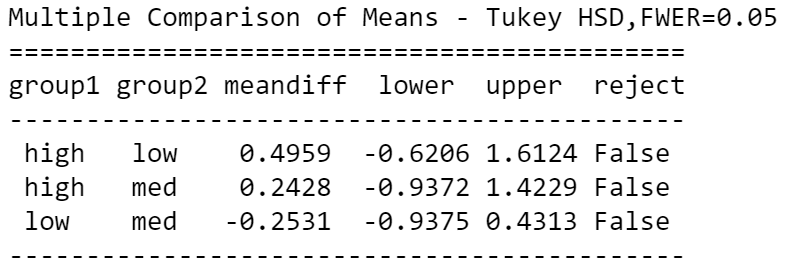

### 1hr: High Frequency Different
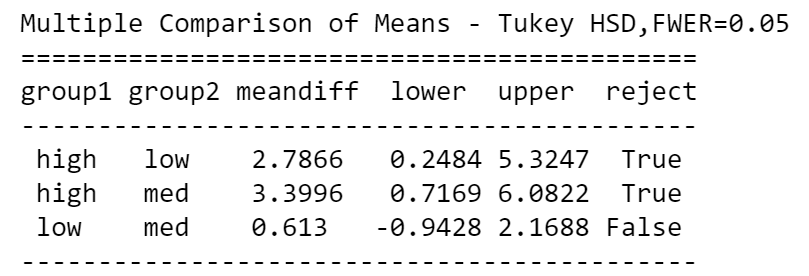

# <center> Region <center>

In [22]:
region_summary = cdata[['diff', 'region']].groupby(['region']).agg(['count', 'sum', 'median', 'mean', 'std']).reset_index()
region_summary

region   diff                                             
                      count           sum    median      mean        std
0   East King County   9889 -10202.262753 -0.078902 -1.031678   7.684523
1            Express   4690  -4945.992239  0.595640 -1.054583  22.691250
2  North King County   3299  -3559.038922 -0.276634 -1.078824   7.297703
3            Seattle  30766 -61617.916583 -0.600694 -2.002793   9.408797
4  South King County  11355  -9705.968967 -0.073914 -0.854775   7.115106

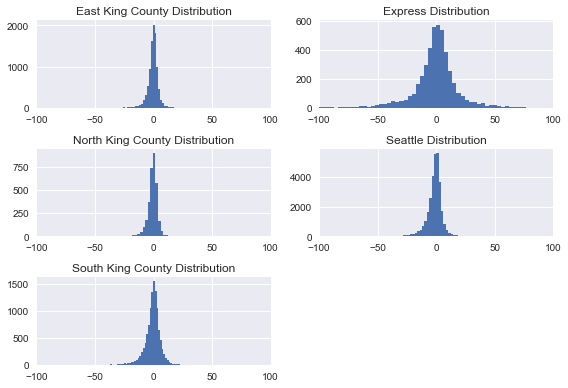

In [23]:
regions = region_summary['region']

fig=plt.figure()
i = 1
for r in regions:
    ax=fig.add_subplot(3,2,i)
    cdata[cdata['region'] == r]['diff'].hist(bins=100,ax=ax)
    plt.xlim(-100, 100)
    ax.set_title(r + " Distribution")
    i += 1
fig.tight_layout()  # Improves appearance a bit.
plt.show()

fig.savefig(file_path + 'evaluation/bias_plots/' + agg_level + '/RegionDistributions.png')

In [24]:
EKC = cdata[cdata['region'] == regions[0]]['diff']
Express = cdata[cdata['region'] == regions[1]]['diff']
NKC = cdata[cdata['region'] == regions[2]]['diff']
Seattle = cdata[cdata['region'] == regions[3]]['diff']
SKC = cdata[cdata['region'] == regions[4]]['diff']

f, p = stats.f_oneway(EKC, Express, NKC, Seattle, SKC)
print ('One-way ANOVA')
print ('=============')
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 37.51735925601046
P value: 2.155093345662146e-31 



### 15min: Reject
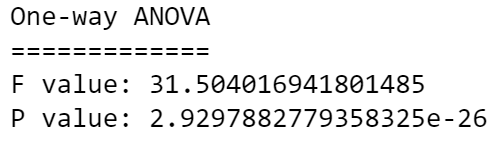

### 30min: Reject

### 1hr:

In [25]:
mc = MultiComparison(cdata['diff'], cdata['region'])
result = mc.tukeyhsd()
print(result)

         Multiple Comparison of Means - Tukey HSD,FWER=0.05        
      group1            group2      meandiff  lower   upper  reject
-------------------------------------------------------------------
 East King County      Express      -0.0229  -0.5252  0.4794 False 
 East King County North King County -0.0471  -0.6168  0.5225 False 
 East King County      Seattle      -0.9711  -1.2986 -0.6436  True 
 East King County South King County  0.1769  -0.2128  0.5666 False 
     Express      North King County -0.0242  -0.6681  0.6196 False 
     Express           Seattle      -0.9482  -1.3923 -0.5041  True 
     Express      South King County  0.1998   -0.292  0.6916 False 
North King County      Seattle       -0.924   -1.443 -0.4049  True 
North King County South King County  0.224   -0.3363  0.7844 False 
     Seattle      South King County  1.148    0.8369  1.4591  True 
-------------------------------------------------------------------


### 15min: Express Region Different
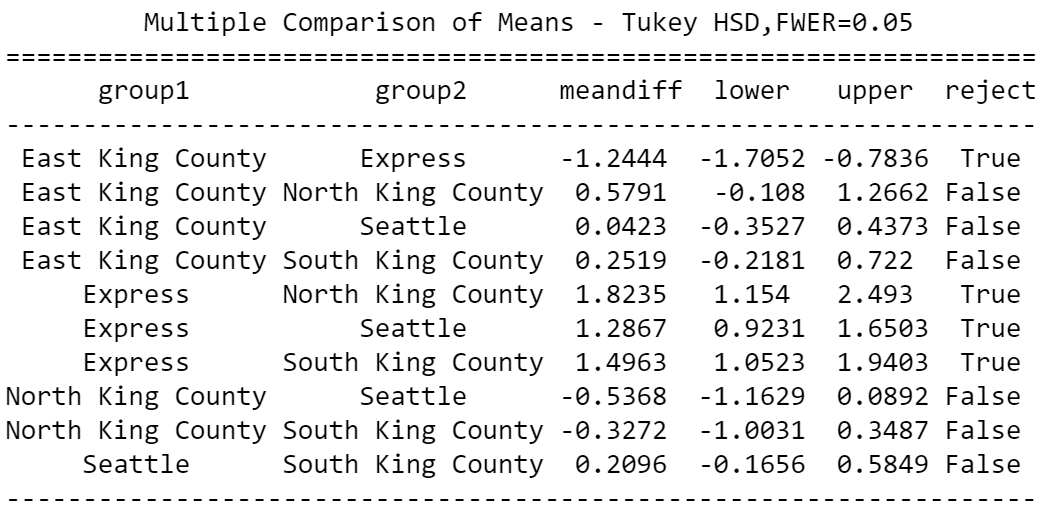

### 30min: SKC vs. Seattle/Express 

### 1hr:

# <center> Region vs. Cluster <center>

In [26]:
regioncluster_summary = cdata[['diff', 'trip_freq', 'region']].groupby(['region', 'trip_freq']).agg(['count', 'sum', 'median', 'mean', 'std']).reset_index()
regioncluster_summary

region trip_freq   diff                                    \
                                 count           sum    median      mean   
0    East King County       low   2540  -2354.825469 -0.120249 -0.927097   
1    East King County       med   7349  -7847.437284 -0.058500 -1.067824   
2             Express       low    559     55.537648  1.046068  0.099352   
3             Express       med   4131  -5001.529886  0.414188 -1.210731   
4   North King County       low   1127  -1544.246692 -0.334433 -1.370228   
5   North King County       med   2172  -2014.792231 -0.217756 -0.927621   
6             Seattle      high  12259 -29631.218423 -0.702488 -2.417099   
7             Seattle       low   2193  -3391.941357 -0.551626 -1.546713   
8             Seattle       med  16314 -28594.756803 -0.539052 -1.752774   
9   South King County       low   5265  -5039.939623 -0.012274 -0.957253   
10  South King County       med   6090  -4666.029344 -0.133242 -0.766179   

               
          std  
0    7.069055  
1    7.886218  
2   12.091184  
3   23.761882  
4   10.064256  
5    5.319924  
6   10.669241  
7    6.480996  
8    8.692042  
9    7.141596  
10   7.091517

# <center> Low Income <center>

One-way ANOVA
F value: 19.65376167692661
P value: 4.6961598987596375e-23 



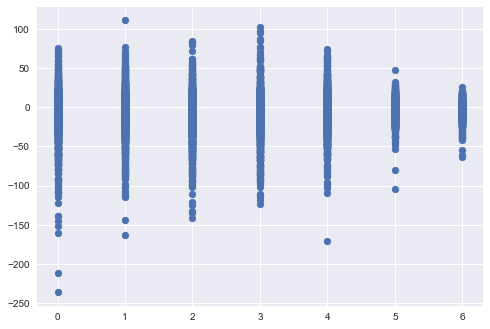

In [27]:
type_o = 'day_of_week'
s = cdata[cdata[type_o] == 0]['diff']
m = cdata[cdata[type_o] == 1]['diff']
t = cdata[cdata[type_o] == 2]['diff']
w = cdata[cdata[type_o] == 3]['diff']
th = cdata[cdata[type_o] == 4]['diff']
f = cdata[cdata[type_o] == 5]['diff']
sat = cdata[cdata[type_o] == 6]['diff']
# low_h = cdata[(cdata[type_o] > .66) & (cdata[type_o] <= 1)]['diff']

f, p = stats.f_oneway(s, m, t, w, th, f, sat) # Express, NKC, Seattle, SKC)
print ('One-way ANOVA')
print ('=============')
print ('F value:', f)
print ('P value:', p, '\n')


plt.scatter(cdata[type_o], cdata['diff'])

In [30]:
mc = MultiComparison(cdata['diff'], cdata['day_of_week'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.3912   -0.046 0.8284 False 
  0      2     0.3429  -0.0893 0.775  False 
  0      3     0.1534  -0.2827 0.5896 False 
  0      4     0.7443   0.3094 1.1792  True 
  0      5     1.4788   0.9663 1.9913  True 
  0      6      1.29    0.7324 1.8475  True 
  1      2    -0.0484  -0.4795 0.3828 False 
  1      3    -0.2378   -0.673 0.1974 False 
  1      4     0.353   -0.0809 0.787  False 
  1      5     1.0876   0.5759 1.5993  True 
  1      6     0.8987   0.3419 1.4556  True 
  2      3    -0.1894  -0.6196 0.2407 False 
  2      4     0.4014  -0.0274 0.8303 False 
  2      5     1.1359   0.6286 1.6433  True 
  2      6     0.9471   0.3942  1.5    True 
  3      4     0.5909   0.1579 1.0238  True 
  3      5     1.3254   0.8146 1.8362  True 
  3      6     1.1365   0.5805 1.6926  True 
  4      5     0.7345   0.2248 1.2443  True 
  4 

Ttest_indResult(statistic=8.477128759828659, pvalue=2.360693247607022e-17)


C:\Users\mstark\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00, 5.0000e+00,
         1.2000e+01, 9.0000e+00, 1.2000e+01, 9.0000e+00, 1.7000e+01,
         1.8000e+01, 2.7000e+01, 4.4000e+01, 6.6000e+01, 9.7000e+01,
         1.8200e+02, 4.8400e+02, 1.8790e+03, 1.0275e+04, 1.0383e+04,
         1.1090e+03, 2.0400e+02, 9.9000e+01, 4.5000e+01, 2.4000e+01,
         1.5000e+01, 1.9000e+01, 5.0000e+00, 1.0000e+01, 5.0000e+00,
         1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]),
  array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
         2.0000e+00, 2.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+01,
         1.0000e+01, 1.9000e+01,

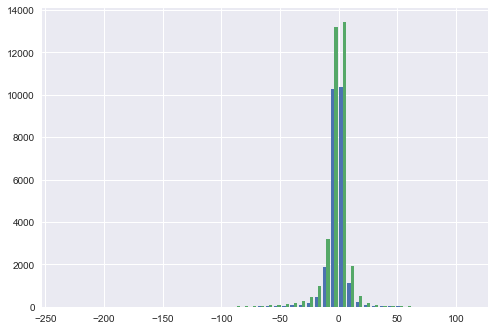

In [29]:
type_o = 'summer'
summer = cdata[cdata[type_o] == 0]['diff']
winter = cdata[cdata[type_o] == 1]['diff']

print(stats.ttest_ind(summer, winter, equal_var=False))

plt.hist([summer, winter], bins = 50)

In [ ]:
stats.ttest_ind(low_s, low_m, equal_var=False)

In [ ]:
#frequency
#region
#low income
#day of week
#summer
#senior
#youth

In [ ]:
summer vs winter are different


Maggie: Are there routes that are always overestimated or underestimated, or is it random?
High frequency
Low frequency
Geographic area?
Bias?
etc.


High vs Medium vs Low:

Geographic Area:


